In [1]:
from emboss_needle import serviceRun, serviceGetStatus, serviceGetResult, getResult, printGetResultTypes

In [7]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import time
from tqdm import tqdm
from mpire import WorkerPool

In [35]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from concurrent.futures import as_completed

In [42]:
generated = list(SeqIO.parse("/Users/mzvyagin/Documents/reverse_protein_design/likely-wood-857_1024concat_seqs_reconstructed.fasta", "fasta"))
generated_seqs = [s.seq for s in generated]
generated_protein_seqs = [s.translate(to_stop=True) for s in generated_seqs]

In [5]:
ecoli_wildtype = list(SeqIO.parse("/Users/mzvyagin/Downloads/rcsb_pdb_2PWZ.fasta", "fasta"))[0]

In [6]:
ecoli_wildtype

SeqRecord(seq=Seq('MKVAVLGAAGGIGQALALLLKTQLPSGSELSLYDIAPVTPGVAVDLSHIPTAVK...VNK'), id='2PWZ_1|Chains', name='2PWZ_1|Chains', description='2PWZ_1|Chains A, B[auth C], C[auth E], D[auth G]|Malate dehydrogenase|Escherichia coli (83333)', dbxrefs=[])

In [63]:
def get_needle_score_seqrecord(seq_a: SeqRecord, seq_b: SeqRecord, translate_a: bool=False, translate_b: bool=True) -> (str, float):
    if translate_a:
        a = str(seq_a.seq.translate(to_stop=True))
    else:
        a = str(seq_a.seq)
    if translate_b:
        b = str(seq_b.seq.translate(to_stop=True))
    else:
        b = str(seq_b.seq)
    params = {}
    params['email'] = "mzvyagin@anl.gov"
    params['stype'] = "protein"
    params['baseUrl'] = 'https://www.ebi.ac.uk/Tools/services/rest/emboss_needle'
    params['asequence'] = a
    params['bsequence'] = b
    job_id = serviceRun(email="mzvyagin@anl.gov", title=None, params=params)
    # check to see if finished
    job_status = None
    while job_status != "FINISHED":
        job_status = serviceGetStatus(job_id)
    # now that job is finished, get results
    output = serviceGetResult(job_id, "out")
    # parse out the score
    output_split = output.split("\n")
    for i in output_split:
        if "Score" in i:
            just_score = float(i.split(":")[-1].strip())
            return (seq_a, seq_b, just_score)

In [64]:
futures = []
results = []
with ThreadPoolExecutor(max_workers=128) as pool:
    for protein_string in tqdm(generated):
        # print(get_needle_score(str(ecoli_wildtype.seq), protein_string))
        future = pool.submit(get_needle_score_seqrecord, ecoli_wildtype, protein_string)
        futures.append(future)
        # results.append(future.result(timeout=60))
    
    # futures = pool.map(get_needle_score, tqdm(align_seqs), timeout=60)
    for i in tqdm(as_completed(futures), total=len(futures)):
        results.append(i.result())
# for future in as_completed(futures):
#     results.append(future.result())

100%|██████████| 1024/1024 [01:31<00:00, 11.18it/s]


In [66]:
just_scores = [x[2] for x in results]

In [67]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'NEEDLE Pairwise Score against 2PWZ_1')

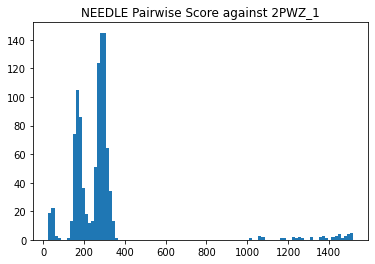

In [68]:
plt.hist(just_scores, bins=100)
plt.title("NEEDLE Pairwise Score against 2PWZ_1")

In [71]:
top_scores = []
for x in results:
    if x[2] >= 1000:
        top_scores.append(x)

In [72]:
len(top_scores)

44

In [74]:
top_mdh_generated = [x[1] for x in top_scores]

In [75]:
SeqIO.write(top_mdh_generated, "likely-wood-857-44seqs_with_needle_score_above_1000_2PWZ.fasta", "fasta")

44

In [78]:
import pickle
with open("likely-wood-287-seqs_needle_scores_against_2pwz.pkl", "wb") as f:
    f.write(pickle.dumps(results))

In [1]:
import json

In [81]:
str_results = []
for x in results:
    str_results.append((str(x[0].seq), str(x[1].seq), x[2]))

In [83]:
with open("likely-wood-287-seqs_needle_scores_against_2pwz.json", "w") as f:
    f.write(json.dumps(str_results))

In [2]:
with open("likely-wood-287-seqs_needle_scores_against_2pwz.json", "r") as f:
    str_results = json.load(f)

In [31]:
top_scores = []
for x in str_results:
    if x[2] >= 1000:
        top_scores.append(x)

In [32]:
top_44_mdh = [x[1] for x in top_scores]

In [34]:
len(top_44_mdh)

44

In [8]:
folded_97 = list(SeqIO.parse("likely-wood-857-sampled_from_clusters_97_seqs.fasta", "fasta"))

In [9]:
folded_97_strings = [str(x.seq) for x in folded_97]

In [24]:
top_44_mdh

['ATGGCTAAGGTTTCTATTATCGGCGCTGGGATGACCGGCTCCACCACCGCGCACTGGCTGGCGGAACGCGAAATCGCTGATATTGTCCTGGTCGACATTGTGGAGGGAATGCCCCAGGGAAAAGCCCTGGATTTGCAGGAAGCCATGCCCATTATCGGCAAGGATGTCAGCATCATCGGCGCGAACGACTACGCCGCGACCAAAGGCTCCGATATCATCATCATCACCGCCGGGCTGCCGCGCAAGCCAGGGATGAGTCGCGACGATCTGCTCACCACCAATGCCGAAATTGTGGGCAAAGCCGCGACCGAGACTATCAAATATTCGCCGGACGCCATTTATATTGTGTTGACCAATCCGCTCGATGTGATGACCTACCTGACGATGAAGAAAACCGGCCTGCCGCGTGAACGCGTGATTGGCCAGGCGGGCATCCTGGACTCCGCCCGCATGCGCGCCTTTGTTGCCATGGAAACCGGGGTGAGCGTTGAGAATATCAATTGCTACGTGTTGGGCGGTCACGGCGACGAGATGGTCCCGCTGACGCGTCATTCCAATGTGGCCGGCATTCCGCTGCGCGACTACCTGCCCGCCGATAAACTCGAGGCCATCGTGCAGCGCACCCGCAAAGGCGGCGGCGAGATTGTCAACCTTCTTAAGACCGGCTCGGCCTTCTACGCGCCGTCTGCCGCCATTGCCCAGATGGCGGAAGCTATTCTGAAGGATAAGCACCTGATCGTTCCCTGCGCCGCCTACATGCAGGGCGAGTACGGCCTCAATGACATGTTCTTTGGTGTGCCCGTGCAGTTGGGGCGCAAAGGGATCGAAAAGGTGATCGAATACGATCTGGATGCCGATGAAAAGGCCGCCTTCAAAAAATCGGCGGAGGCGGTGAAAGAAACCCACGAGGCGCTTAAGCTGATGAAAATTCTTTAG',
 'ATGGCAAATAAGAGAATTGCGCTTGTTGGTGCTGGAAATATTGGTGGAACTTTAGCT

In [23]:
folded_97_strings

['ATGACAAAGGTAAGCATCGTCGGTGCAGCCGGCACCGTCGGCGCCGCGGCAGGCTACAATCTCGCACTGCGCGACGTGGTCGATGAGATCGTCTACGTCGACATCCCGGATCAGGAAGACACGACGGTCGGACAGGCCGCCGACACCAACCACGGCATCGCCTACGACTCGAACACGACAGTCCGGCAGGGCGAGTACGCGGACACCGCCGGATCGGACGTGGTCGTCATCACCGCCGGCATCCCGCGCCAGCCCGGGCAGACCCGCATCGACCTCGCCGGCGACAACGCGCCGATCATGGAGGACATCCAGTCCTCGCTGGCGGAGCACAACGACGACTTCGTCACCGTCACCACCTCGAACCCGGTCGACCTGCTCAACCGCCACCTCTACGAGGCCGGCGACCGCGACCGCGAGCACGTCATCGGCTTCGGCGGCCGCCTGGACTCCGCGCGCTTCCGCTACGTCCTCAGCCAGCGCTACGACGCGCCCGTCCAGAACGTCGACGCGACGATTCTCGGCGAGCACGGCGACGCGCAGGTCCCCGTGTTCTCGAAGGTCCGCGTCGACGGCCACGACCTGGAGTTCACCGCGGACGAGAAGGAAGAGATTCTGGCGGATCTCCAGCAGTCCGCGATGGACGTCATCGAGCGCAAGGGCGCGACCCAGTGGGGGCCCGCCACGGGCGTCGCCCACATGGTCGAAGCCATCCTCAACGACACCGGCGAGGTGCTGCCCTGCTCGGTCGTCCTCGACGGCGAGTTCGGCCACGAGGACACCGCGTTCGGCGTCCCCGTCAGGCTCGGTTCGAACGGCGTCGAGGAAGTCGTCGAGTGGGACCTCGACGAGTACGAGTCGGACCTGATGGACGACGCCGCCGAGAAGCTCTCCGACCAGTACGACAAGATCGCCTAA',
 'ATGCCCGAGACCACGACGACCATCACCATCACGGGCGGCGGCGGCCAGATCGGCTACGCGCTGATGTTCCGCATCGCC

In [10]:
import numpy as np

In [36]:
intersect = [i for i in tqdm(top_44_mdh) if i in folded_97_strings]

100%|██████████| 44/44 [00:00<00:00, 143283.68it/s]


In [37]:
len(intersect)

6

In [38]:
intersect == folded_97_strings

False

In [47]:
# find the records of already folded intersect
for i in intersect:
    for j in folded_97:
        if i == str(j.seq):
            print(j.name)

MDHSyntheticSequence-LikelyWood857_32_index270
MDHSyntheticSequence-LikelyWood857_69_index276
MDHSyntheticSequence-LikelyWood857_281_index511
MDHSyntheticSequence-LikelyWood857_295_index527
MDHSyntheticSequence-LikelyWood857_424_index670
MDHSyntheticSequence-LikelyWood857_732_index1011
